# **Install PyTorch**





In [ ]:
!pip install -U torch torchvision tqdm lxml

# **Mounting Goodle Drive & Set Path**

In [ ]:
# === Mount google drive ============
from google.colab import drive
drive.mount('/content/drive')

# ===Set path for PASCAL VOC dataset
import os
DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc"

Mounted at /content/drive


# **Dataset Loader for Pascal VOC**

In [ ]:
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import os

class VOCDataset(Dataset):
    def __init__(self, root, image_set="train", transforms=None):
        self.root = root
        self.transforms = transforms
        self.image_dir = os.path.join(root, "JPEGImages")
        self.ann_dir = os.path.join(root, "Annotations")

        with open(os.path.join(root, "ImageSets", "Main", f"{image_set}.txt")) as f:
            self.image_ids = [x.strip() for x in f.readlines()]

        self.class_map = {"object": 1, "object_alt": 2}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, img_id + ".jpg")
        ann_path = os.path.join(self.ann_dir, img_id + ".xml")

        img = Image.open(img_path).convert("RGB")
        target = self.parse_voc_xml(ann_path)

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def parse_voc_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            name = obj.find("name").text.strip()
            label = self.class_map.get(name, 1)

            bbox = obj.find("bndbox")
            xmin = int(float(bbox.find("xmin").text))
            ymin = int(float(bbox.find("ymin").text))
            xmax = int(float(bbox.find("xmax").text))
            ymax = int(float(bbox.find("ymax").text))

            # Skip boxes with width or height less than 1
            if (xmax - xmin) < 1 or (ymax - ymin) < 1:
                continue

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        if len(boxes) == 0:
            boxes = [[0, 0, 1, 1]]  # fallback dummy box
            labels = [0]            # background class

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        return target

## **Checking for Missing Files in the train.txt file**

In [ ]:
# Debug: Check if any image IDs listed in train.txt are missing from JPEGImages/
from pathlib import Path

image_dir = Path(DATASET_DIR) / "JPEGImages"
with open(Path(DATASET_DIR) / "ImageSets" / "Main" / "train.txt") as f:
    listed_images = [x.strip() + ".jpg" for x in f.readlines()]

missing = [f for f in listed_images if not (image_dir / f).exists()]

print(f"Missing files: {len(missing)}")
for m in missing[:10]:  # Preview the first 10
    print(m)

Missing files: 1251
Line 2_CNav_7500_29500_8000_30000.jpg
Line 2_CNav_1000_5000_1500_5500.jpg
Line 2_CNav_6000_43500_6500_44000.jpg
Line 2_CNav_4000_36500_4500_37000.jpg
Line 2_CNav_6500_23500_7000_24000.jpg
Line 2_CNav_2500_52000_3000_52500.jpg
Line 2_CNav_4500_31500_5000_32000.jpg
Line 2_CNav_9500_51000_10000_51500.jpg
Line 2_CNav_2500_51500_3000_52000.jpg
Line 2_CNav_7000_35500_7500_36000.jpg


## **Backing up old train.txt and val.txt used when doing 5 Epochs**

In [ ]:
import shutil
main_dir = Path(DATASET_DIR) / "ImageSets" / "Main"
shutil.copy(main_dir / "train.txt", main_dir / "train_original.txt")
shutil.copy(main_dir / "val.txt", main_dir / "val_original.txt")
print("Backed up original train.txt and val.txt")

Backed up original train.txt and val.txt


## **Rebuild Clean Splits**

In [ ]:
from pathlib import Path
import random

jpeg_dir = Path(DATASET_DIR) / "JPEGImages"
image_files = list(jpeg_dir.glob("*.jpg"))

# Shuffle and split 80/20
random.seed(42)
random.shuffle(image_files)
split_idx = int(len(image_files) * 0.8)

train_ids = [f.stem for f in image_files[:split_idx]]
val_ids = [f.stem for f in image_files[split_idx:]]

main_dir = Path(DATASET_DIR) / "ImageSets" / "Main"
main_dir.mkdir(parents=True, exist_ok=True)

with open(main_dir / "train.txt", "w") as f:
    for id in train_ids:
        f.write(id + "\n")

with open(main_dir / "val.txt", "w") as f:
    for id in val_ids:
        f.write(id + "\n")

print(f"Rebuilt train.txt with {len(train_ids)} entries")
print(f"Rebuilt val.txt with {len(val_ids)} entries")

Rebuilt train.txt with 1430 entries
Rebuilt val.txt with 358 entries


# **Re-runing Check Cell**

In [ ]:
# Debug: Check if any image IDs listed in train.txt are missing from JPEGImages/
image_dir = Path(DATASET_DIR) / "JPEGImages"
with open(Path(DATASET_DIR) / "ImageSets" / "Main" / "train.txt") as f:
    listed_images = [x.strip() + ".jpg" for x in f.readlines()]

missing = [f for f in listed_images if not (image_dir / f).exists()]

print(f"Missing files: {len(missing)}")
for m in missing[:10]:  # Preview a few missing entries
    print(m)

Missing files: 0


# **Load Faster R-CNN and Start Training with 20 Epochs**

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models import resnet50
from torchvision.ops import MultiScaleRoIAlign
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

# Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create anchor sizes similar to what DANN model used (for fair comparison)
anchor_generator = AnchorGenerator(
    sizes=((8, 16, 32),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# Load ResNet-50 backbone (pretrained on ImageNet)
# We remove the final classification layers since Faster R-CNN will use it as feature extractor
backbone = resnet50(weights='IMAGENET1K_V1')
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
backbone.out_channels = 2048  # Required for Faster R-CNN to know how many features it gets

# Create RoI pooling (this is where the model pools object proposals)
roi_pooler = MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# Build the full Faster R-CNN model (backbone + anchor gen + RoI pooling)
model = FasterRCNN(
    backbone=backbone,
    num_classes=3,  # 0 = background, 1 = object, 2 = object_alt
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

model.to(device)

# Load Pascal VOC dataset (already converted) with same transform as training
transform = T.ToTensor()
train_dataset = VOCDataset(DATASET_DIR, image_set="train", transforms=transform)
val_dataset = VOCDataset(DATASET_DIR, image_set="val", transforms=transform)

# DataLoaders (batch_size=2 was stable during DANN training)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Optimizer (AdamW works better than plain Adam, since it also adds weight decay for regularization phase)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4, weight_decay=1e-4)

# Train model for 20 full epochs (like we did for 3_dann_20epoch_tuned.ipynb)
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Total Loss: {running_loss:.4f}")

Epoch 1/20: 100%|██████████| 715/715 [09:41<00:00,  1.23it/s]


Epoch 1/20 | Total Loss: 1950.4852


Epoch 2/20: 100%|██████████| 715/715 [01:34<00:00,  7.53it/s]


Epoch 2/20 | Total Loss: 1876.2603


Epoch 3/20: 100%|██████████| 715/715 [01:34<00:00,  7.53it/s]


Epoch 3/20 | Total Loss: 1809.5848


Epoch 4/20: 100%|██████████| 715/715 [01:35<00:00,  7.51it/s]


Epoch 4/20 | Total Loss: 1832.5079


Epoch 5/20: 100%|██████████| 715/715 [01:34<00:00,  7.53it/s]


Epoch 5/20 | Total Loss: 1755.9088


Epoch 6/20: 100%|██████████| 715/715 [01:34<00:00,  7.53it/s]


Epoch 6/20 | Total Loss: 1739.0031


Epoch 7/20: 100%|██████████| 715/715 [01:34<00:00,  7.54it/s]


Epoch 7/20 | Total Loss: 1715.7854


Epoch 8/20: 100%|██████████| 715/715 [01:34<00:00,  7.54it/s]


Epoch 8/20 | Total Loss: 1659.2872


Epoch 9/20: 100%|██████████| 715/715 [01:34<00:00,  7.53it/s]


Epoch 9/20 | Total Loss: 1639.5861


Epoch 10/20: 100%|██████████| 715/715 [01:35<00:00,  7.52it/s]


Epoch 10/20 | Total Loss: 1598.8357


Epoch 11/20: 100%|██████████| 715/715 [01:34<00:00,  7.53it/s]


Epoch 11/20 | Total Loss: 1558.2699


Epoch 12/20: 100%|██████████| 715/715 [01:35<00:00,  7.53it/s]


Epoch 12/20 | Total Loss: 1546.3034


Epoch 13/20: 100%|██████████| 715/715 [01:35<00:00,  7.51it/s]


Epoch 13/20 | Total Loss: 1477.7721


Epoch 14/20: 100%|██████████| 715/715 [01:34<00:00,  7.54it/s]


Epoch 14/20 | Total Loss: 1413.5243


Epoch 15/20: 100%|██████████| 715/715 [01:35<00:00,  7.51it/s]


Epoch 15/20 | Total Loss: 1391.1248


Epoch 16/20: 100%|██████████| 715/715 [01:35<00:00,  7.49it/s]


Epoch 16/20 | Total Loss: 1344.7083


Epoch 17/20: 100%|██████████| 715/715 [01:35<00:00,  7.50it/s]


Epoch 17/20 | Total Loss: 1233.7764


Epoch 18/20: 100%|██████████| 715/715 [01:35<00:00,  7.50it/s]


Epoch 18/20 | Total Loss: 1236.4726


Epoch 19/20: 100%|██████████| 715/715 [01:35<00:00,  7.52it/s]


Epoch 19/20 | Total Loss: 1193.4091


Epoch 20/20: 100%|██████████| 715/715 [01:35<00:00,  7.53it/s]

Epoch 20/20 | Total Loss: 1138.5190


# **Save Model**

In [ ]:
# Save the 20-epoch model
torch.save(model.state_dict(), "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_20epoch.pth")

# **Full Inference: Baseline 20 Epoch**

In [ ]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import resnet50
from torchvision.ops import MultiScaleRoIAlign
from torchvision.transforms import ToTensor

# Match model structure from training
backbone = resnet50(weights='IMAGENET1K_V1')
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
backbone.out_channels = 2048

anchor_generator = AnchorGenerator(sizes=((8, 16, 32),), aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

# Build full model
model = FasterRCNN(
    backbone=backbone,
    num_classes=3,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

# Load your saved weights
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# Inference loop
all_preds = []

for img_path in IMG_DIR.glob("*.jpg"):
    image_pil = Image.open(img_path).convert("RGB")
    image_tensor = ToTensor()(image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)[0]

    boxes = output["boxes"].cpu()
    scores = output["scores"].cpu()
    labels = output["labels"].cpu()

    img_np = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)

    for i in range(len(boxes)):
        score = scores[i].item()
        if score < 0.5:
            continue

        x1, y1, x2, y2 = boxes[i].int().tolist()
        class_id = labels[i].item()

        all_preds.append({
            "filename": img_path.name,
            "class_id": class_id,
            "score": score,
            "xmin": x1,
            "ymin": y1,
            "xmax": x2,
            "ymax": y2,
        })

        # Draw box
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_np, f"{score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

    # Save annotated image
    out_path = OUTPUT_DIR / img_path.name
    cv2.imwrite(str(out_path), img_np)

# Save predictions to CSV
df = pd.DataFrame(all_preds)
df.to_csv(PRED_CSV, index=False)

print(f"Inference complete. Visuals saved to: {OUTPUT_DIR}")
print(f"Predictions saved to: {PRED_CSV}")

Inference complete. Visuals saved to: /content/drive/MyDrive/sonar-object-detection/outputs/baseline_20epoch_vis
Predictions saved to: /content/drive/MyDrive/sonar-object-detection/outputs/preds_baseline_20epoch.csv


## **Visualizations**

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

def visualize(model, dataset_root, num_images=5, image_set="val", confidence_threshold=0.5):
    from PIL import Image
    import cv2
    import torch

    # Load the dataset
    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for i in range(num_images):
        img, _ = dataset[i]
        img_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)[0]

        img_np = img.mul(255).byte().permute(1, 2, 0).cpu().numpy()
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR).copy()

        for box, score in zip(output["boxes"], output["scores"]):
            if score < confidence_threshold:
                continue
            x1, y1, x2, y2 = box.int().tolist()
            cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_np, f"{score:.2f}", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

        plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Image {i+1} — Baseline 20 Epochs")
        plt.show()

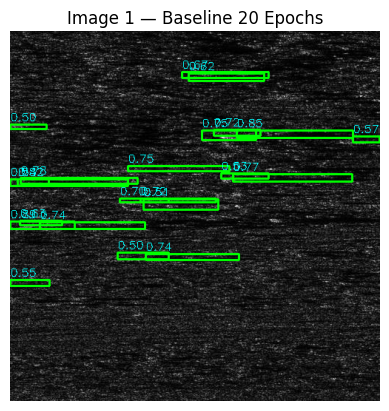

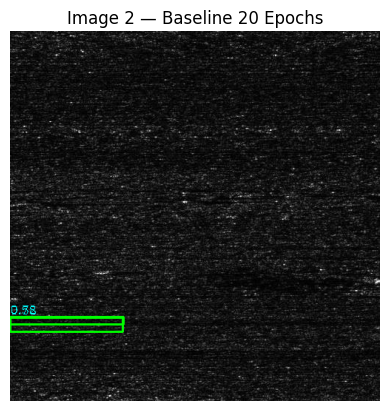

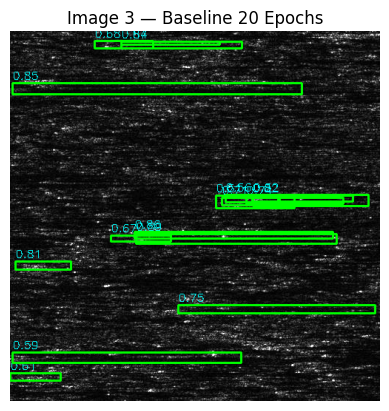

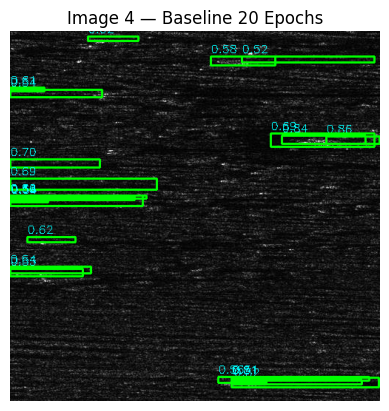

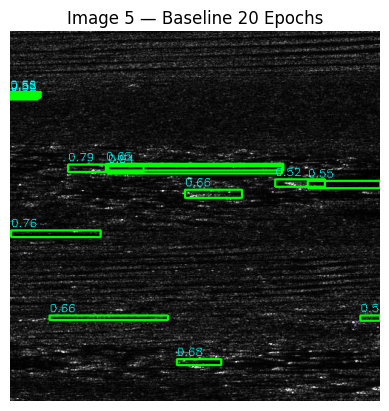

In [ ]:
visualize(
    model=model,
    dataset_root="/content/drive/MyDrive/sonar-object-detection/data/line2voc",
    num_images=5,
    image_set="val",  # or "train" can be used if training previews is wanted
    confidence_threshold=0.5
)

# **Install TorchMetrics**

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

## **evaluate_model.py**

In [ ]:
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models import resnet50
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign

# Set device (GPU A100 used)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build same model structure used during training
backbone = resnet50(weights='IMAGENET1K_V1')
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
backbone.out_channels = 2048

anchor_generator = AnchorGenerator(
    sizes=((8, 16, 32),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

roi_pooler = MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

model = FasterRCNN(
    backbone=backbone,
    num_classes=3,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

# Load my trained 20-epoch weights
MODEL_PATH = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_20epoch.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# Evaluation function for val set
def evaluate(model, dataset_root, batch_size=4, image_set="val"):
    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    metric = MeanAveragePrecision()

    with torch.no_grad():
        for imgs, targets in loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(imgs)

            preds = []
            targs = []
            for o, t in zip(outputs, targets):
                # If there are no predictions for a given image, skip it
                if len(o["boxes"]) == 0:
                    continue

                preds.append({
                    "boxes": o["boxes"].cpu(),
                    "scores": o["scores"].cpu(),
                    "labels": o["labels"].cpu()
                })
                targs.append({
                    "boxes": t["boxes"].cpu(),
                    "labels": t["labels"].cpu()
                })

            # Only update metric if predictions were actually made
            if preds and targs:
                metric.update(preds, targs)

    results = metric.compute()
    print("\nEvaluation Results — Baseline Model (20 Epochs):")
    for k, v in results.items():
        print(f"{k}: {v:.4f}")

# Run it
evaluate(model, "/content/drive/MyDrive/sonar-object-detection/data/line2voc")


Evaluation Results — Baseline Model (20 Epochs):
map: 0.0253
map_50: 0.1020
map_75: 0.0022
map_small: 0.0185
map_medium: 0.0398
map_large: 0.0369
mar_1: 0.0094
mar_10: 0.0492
mar_100: 0.1118
mar_small: 0.0930
mar_medium: 0.1520
mar_large: 0.1083
map_per_class: -1.0000
mar_100_per_class: -1.0000
classes: 1.0000


## **Load Faster R-CNN and Start Training with Preprocessed Data**

### Train Faster RCNN Model (20 Epoch) on Denoised Data

In [ ]:
# allow importing my custom dataset class
import sys
sys.path.append('/content/drive/MyDrive/sonar-object-detection/scripts')
from voc_dataset import VOCDataset

import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as T
from tqdm import tqdm
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# path to the preprocessed (denoised) dataset
DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed"

# apply basic transform
transform = T.ToTensor()

# load train + val sets
train_dataset = VOCDataset(DATASET_DIR, image_set="train", transforms=transform)
val_dataset = VOCDataset(DATASET_DIR, image_set="val", transforms=transform)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# load pretrained COCO weights
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)

# update classification head: 2 classes + background
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# send to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# AdamW works well for sonar
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4)

# train for 20 epochs (15 epochs increase from original 5 epochs)
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

# save the model checkpoint
checkpoint_dir = "/content/drive/MyDrive/sonar-object-detection/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

torch.save(model.state_dict(), os.path.join(checkpoint_dir, "baseline_frcnn_preprocessed_20epoch.pth"))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 193MB/s]
Epoch 1/20: 100%|██████████| 626/626 [18:04<00:00,  1.73s/it]


Epoch 1, Loss: 728.6572


Epoch 2/20: 100%|██████████| 626/626 [00:58<00:00, 10.70it/s]


Epoch 2, Loss: 682.1794


Epoch 3/20: 100%|██████████| 626/626 [00:58<00:00, 10.71it/s]


Epoch 3, Loss: 657.9028


Epoch 4/20: 100%|██████████| 626/626 [00:58<00:00, 10.74it/s]


Epoch 4, Loss: 643.7660


Epoch 5/20: 100%|██████████| 626/626 [00:58<00:00, 10.72it/s]


Epoch 5, Loss: 632.9010


Epoch 6/20: 100%|██████████| 626/626 [00:58<00:00, 10.73it/s]


Epoch 6, Loss: 617.6957


Epoch 7/20: 100%|██████████| 626/626 [00:58<00:00, 10.72it/s]


Epoch 7, Loss: 610.5932


Epoch 8/20: 100%|██████████| 626/626 [00:58<00:00, 10.74it/s]


Epoch 8, Loss: 597.0113


Epoch 9/20: 100%|██████████| 626/626 [00:58<00:00, 10.75it/s]


Epoch 9, Loss: 580.4791


Epoch 10/20: 100%|██████████| 626/626 [00:58<00:00, 10.73it/s]


Epoch 10, Loss: 575.0820


Epoch 11/20: 100%|██████████| 626/626 [00:58<00:00, 10.74it/s]


Epoch 11, Loss: 559.1796


Epoch 12/20: 100%|██████████| 626/626 [00:58<00:00, 10.74it/s]


Epoch 12, Loss: 548.4669


Epoch 13/20: 100%|██████████| 626/626 [00:58<00:00, 10.75it/s]


Epoch 13, Loss: 530.8875


Epoch 14/20: 100%|██████████| 626/626 [00:58<00:00, 10.74it/s]


Epoch 14, Loss: 514.0513


Epoch 15/20: 100%|██████████| 626/626 [00:58<00:00, 10.71it/s]


Epoch 15, Loss: 495.2332


Epoch 16/20: 100%|██████████| 626/626 [00:58<00:00, 10.70it/s]


Epoch 16, Loss: 478.7887


Epoch 17/20: 100%|██████████| 626/626 [00:58<00:00, 10.72it/s]


Epoch 17, Loss: 463.6635


Epoch 18/20: 100%|██████████| 626/626 [00:58<00:00, 10.75it/s]


Epoch 18, Loss: 446.4401


Epoch 19/20: 100%|██████████| 626/626 [00:58<00:00, 10.77it/s]


Epoch 19, Loss: 424.4921


Epoch 20/20: 100%|██████████| 626/626 [00:58<00:00, 10.79it/s]


Epoch 20, Loss: 405.8524


## **Evaluation of Model with Denoised Data**

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

In [ ]:
# evaluate_denoised_model.py
# Evaluate the Faster R-CNN trained on denoised sonar data

import sys
sys.path.append('/content/drive/MyDrive/sonar-object-detection/scripts')
from voc_dataset import VOCDataset

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build model architecture
model = fasterrcnn_resnet50_fpn(weights=None)
num_classes = 3  # 2 objects + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Load trained weights
checkpoint_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/denoised_fasterrcnn.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Evaluation function
def evaluate(model, dataset_root, image_set="val", batch_size=4):
    model.eval()
    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    metric = MeanAveragePrecision()

    with torch.no_grad():
        for imgs, targets in loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(imgs)

            preds = []
            targs = []
            for o, t in zip(outputs, targets):
                if o["boxes"].nelement() == 0:
                    continue  # skip if model made no predictions

                preds.append({
                    "boxes": o["boxes"].cpu(),
                    "scores": o["scores"].cpu(),
                    "labels": o["labels"].cpu()
                })
                targs.append({
                    "boxes": t["boxes"].cpu(),
                    "labels": t["labels"].cpu()
                })

            if preds and targs:
                metric.update(preds, targs)

    # Final metrics
    results = metric.compute()
    print("\nEvaluation Results — Faster R-CNN (20 Epochs, Denoised Dataset):")
    for k, v in results.items():
        print(f"{k}: {v:.4f}")

# Run evaluation
evaluate(model, "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed")


Evaluation Results — Faster R-CNN (20 Epochs, Denoised Dataset):
map: 0.0475
map_50: 0.1693
map_75: 0.0143
map_small: 0.0352
map_medium: 0.0701
map_large: 0.0257
mar_1: 0.0137
mar_10: 0.0728
mar_100: 0.1677
mar_small: 0.1311
mar_medium: 0.2522
mar_large: 0.0250
map_per_class: -1.0000
mar_100_per_class: -1.0000
classes: 1.0000


### visualize denoised predictions

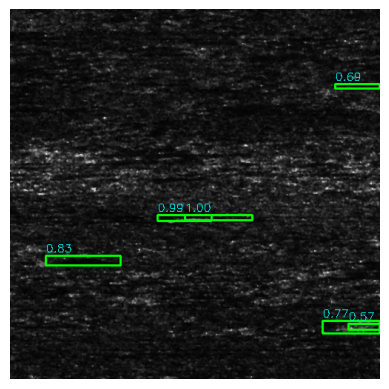

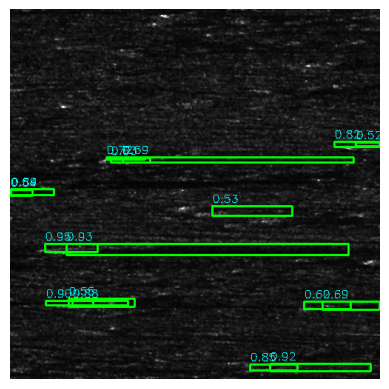

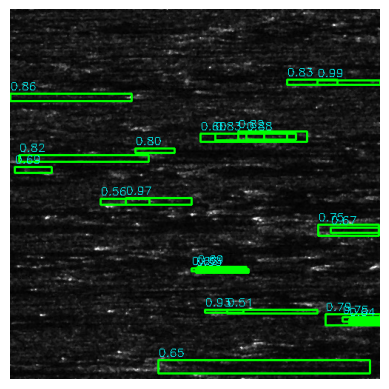

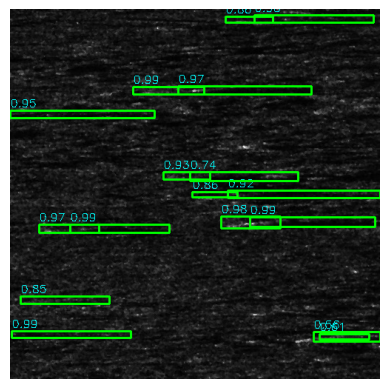

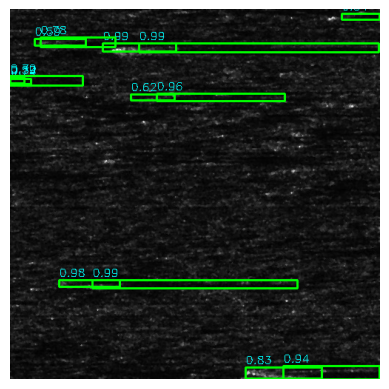

In [ ]:
# Show visual results from the 20-epoch denoised model

import sys
sys.path.append('/content/drive/MyDrive/sonar-object-detection/scripts')
from voc_dataset import VOCDataset

import torch
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToTensor

# model and data paths
MODEL_PATH = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_preprocessed_20epoch.pth"
DATASET_ROOT = "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed"

# optionally save predictions
SAVE_OUTPUT = True
SAVE_DIR = "/content/drive/MyDrive/sonar-object-detection/outputs/vis_denoised_20epoch"
os.makedirs(SAVE_DIR, exist_ok=True)

# score threshold for displaying boxes
SCORE_THRESH = 0.5

# load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn(weights=None)
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# load validation set
dataset = VOCDataset(DATASET_ROOT, image_set="val", transforms=ToTensor())

# visualize N samples
for i in range(5):
    img, _ = dataset[i]
    img_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)[0]

    # convert to numpy for cv2
    img_np = img.mul(255).byte().permute(1, 2, 0).cpu().numpy()
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR).copy()

    for box, score in zip(output["boxes"], output["scores"]):
        if score < SCORE_THRESH:
            continue
        x1, y1, x2, y2 = box.int().tolist()
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_np, f"{score:.2f}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

    # show in notebook
    plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    # optionally save the visualization
    if SAVE_OUTPUT:
        save_path = os.path.join(SAVE_DIR, f"val_sample_{i}.jpg")
        cv2.imwrite(save_path, img_np)

### Inference denoised batch

In [ ]:
# Run batch inference using 20-epoch Faster R-CNN model on denoised sonar data
import os
import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# set base project path
PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")

# denoised validation images
IMG_DIR = PROJECT_ROOT / "data" / "line2voc_preprocessed" / "JPEGImages"

# model checkpoint trained for 20 epochs
MODEL_PATH = PROJECT_ROOT / "checkpoints" / "baseline_frcnn_preprocessed_20epoch.pth"

# output folders
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "vis_denoised_20epoch"
PRED_CSV = PROJECT_ROOT / "outputs" / "preds_denoised_20epoch.csv"

# create output folders
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PRED_CSV.parent.mkdir(parents=True, exist_ok=True)

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load model + update head
model = fasterrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)

# load trained weights
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# store predictions
all_preds = []

# loop over images
for img_path in IMG_DIR.glob("*.jpg"):
    image_pil = Image.open(img_path).convert("RGB")
    image_tensor = ToTensor()(image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)[0]

    boxes = output["boxes"].cpu()
    scores = output["scores"].cpu()
    labels = output["labels"].cpu()

    img_np = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)

    for i in range(len(boxes)):
        score = scores[i].item()
        if score < 0.5:
            continue

        x1, y1, x2, y2 = boxes[i].int().tolist()
        class_id = labels[i].item()

        all_preds.append({
            "filename": img_path.name,
            "class_id": class_id,
            "score": score,
            "xmin": x1,
            "ymin": y1,
            "xmax": x2,
            "ymax": y2,
        })

        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_np, f"{score:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

    # save image with drawn predictions
    cv2.imwrite(str(OUTPUT_DIR / img_path.name), img_np)

# save all predictions to CSV
df = pd.DataFrame(all_preds)
df.to_csv(PRED_CSV, index=False)

print(f"Inference complete. Visuals saved to: {OUTPUT_DIR}")
print(f"Predictions saved to: {PRED_CSV}")

Inference complete. Visuals saved to: /content/drive/MyDrive/sonar-object-detection/outputs/vis_denoised_20epoch
Predictions saved to: /content/drive/MyDrive/sonar-object-detection/outputs/preds_denoised_20epoch.csv
